## 使用座標作為Input data，(all keyframe)，進行BorderlineSMOTE，使用NN作為模型。

In [23]:
import numpy as np
import pandas as pd
import os
import math
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import cv2
from cv2 import imread, IMREAD_GRAYSCALE
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool2D, Input, Dropout, LSTM, Dense, BatchNormalization, Activation, Reshape
from tensorflow.keras.layers import DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Bidirectional, concatenate, Flatten, MaxPooling1D
from tensorflow.keras.constraints import max_norm
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from time import time
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,ADASYN
from sklearn.preprocessing import LabelEncoder
from collections import Counter


### Read data

Class=0, n=37087 (91.772%)
Class=1, n=2649 (6.555%)
Class=2, n=338 (0.836%)
Class=3, n=338 (0.836%)


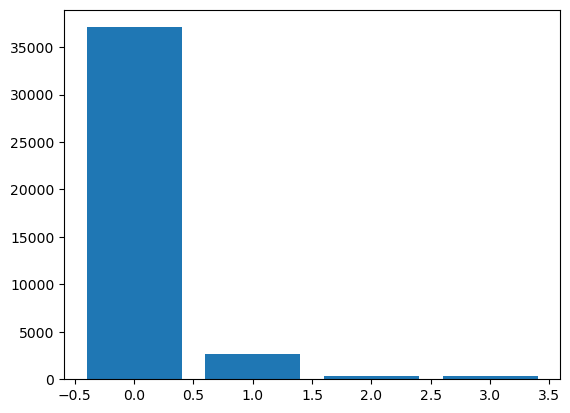

In [25]:
# Load and preprocess your data
ds_x = pd.read_csv(r'D:\\111064555\Work\code\Coordinate\all_coordinates_list.csv')
ds_y = pd.read_csv(r'D:\\111064555\Work\code\Coordinate\label_all_keyframe_add.csv')

# Preprocess data_x
data_x = ds_x['coordinate'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ', dtype=np.float64))

data_y = LabelEncoder().fit_transform(ds_y['keyframe'])
counter = Counter(data_y)
for k,v in counter.items():
    per = v / len(data_y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

    # plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### SMOTE + SPLIT DATA

In [28]:
# 把 data_x 轉換成 Pandas DataFrame
data_x_df = pd.DataFrame(data_x.tolist(), columns=[f'coordinate_{i}' for i in range(69)]) # half=45, all=69

# Spliting the data into train and test
from sklearn.model_selection import train_test_split
X_train,X_temp,y_train,y_temp = train_test_split(data_x_df, data_y, test_size = 0.2,random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_temp, y_temp, test_size = 0.5,random_state=42)

# Check shapes of the split data
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


# SMOTE Training data
# oversampling = SMOTE(random_state=42, k_neighbors = 5)
oversampling = BorderlineSMOTE(random_state=42, k_neighbors=5,kind ='borderline-1')  # 有borderline-2
# oversampling = ADASYN(random_state=42)
X_train_resampled, y_train_resampled= oversampling.fit_resample(X_train, y_train)


# After SMOTE
print(Counter(y_train_resampled))
print(Counter(y_test))
print("After smote:",X_train_resampled.shape,X_test.shape,y_train_resampled.shape,y_test.shape)

Train shape: (32329, 69)
Validation shape: (4041, 69)
Test shape: (4042, 69)
y_train shape: (32329,)
y_val shape: (4041,)
y_test shape: (4042,)
Counter({0: 29699, 1: 29699, 2: 29699, 3: 29699})
Counter({0: 3690, 1: 284, 2: 34, 3: 34})
After smote: (118796, 69) (4042, 69) (118796,) (4042,)


'\nhttps://blog.51cto.com/u_15127669/3596486\n'

Class=0, n=29699 (25.000%)
Class=1, n=29699 (25.000%)
Class=2, n=29699 (25.000%)
Class=3, n=29699 (25.000%)


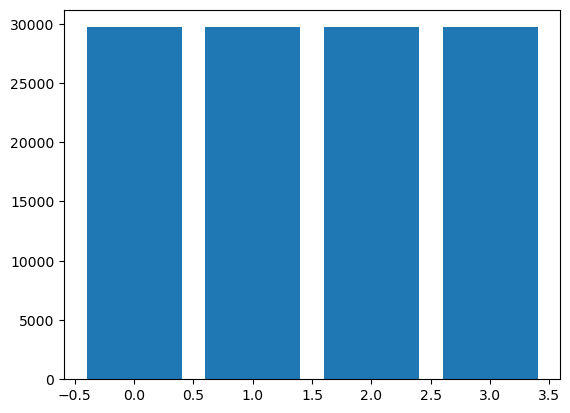

In [29]:
counter = Counter(y_train_resampled)
sorted_counter = sorted(counter.items())
for k,v in sorted_counter:
    per = v / len(y_train_resampled) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [32]:
from keras.utils import to_categorical
num_classes=4
# Assuming y_train_resampled and y_test are your original labels
y_train_resampled_categorical = to_categorical(y_train_resampled, num_classes=num_classes) # num_classes为您的类别总数
y_val_categorical = to_categorical(y_val, num_classes=num_classes)

In [33]:
X_train_resampled.shape

(118796, 69)

### Train

In [34]:
def model_nn(num_classes):
    model = Sequential()
    model.add(Dense(512, activation="relu", input_shape=(X_train_resampled.shape[1],), kernel_regularizer=l2(0.0001)))
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.0001)))
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    return model

def model_1dcnn(num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, strides=4, activation='relu', input_shape=(X_train_resampled.shape[1], 1), kernel_regularizer=l2(0.0001)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def model_lstm(num_classes):
    model = Sequential()    
    model.add(LSTM(units=256, input_shape= (X_train_resampled.shape[1], 1), return_sequences=True))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(128))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = model_nn(num_classes=4)
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", 
                                                                      tf.keras.metrics.AUC(curve="ROC", name="roc_auc",multi_label=False),
                                                                      tf.keras.metrics.AUC(curve="PR", name="pr_auc",multi_label=False)])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               35840     
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 4)                 516       
                                                                 
Total params: 200,580
Trainable params: 200,580
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
3713/3713 [==============================] - 20s 4ms/step - loss: 1.1991 - accuracy: 0.5207 - roc_auc: 0.7954 - pr_auc: 0.5437 - val_loss: 1.2419 - val_accuracy: 0.2811 - val_roc_auc: 0.6775 - val_pr_auc: 0.3152
Epoch 2/500
3713/3713 [==============================] - 16s 4ms/step - loss: 0.9412 - accuracy: 0.6686 - roc_auc: 0.8719 - pr_auc: 0.6909 - val_loss: 1.0795 - val_accuracy: 0.4442 - val_roc_auc: 0.7712 - val_pr_auc: 0.4593
Epoch 3/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.8106 - accuracy: 0.7381 - roc_auc: 0.9026 - pr_auc: 0.7748 - val_loss: 0.9584 - val_accuracy: 0.5328 - val_roc_auc: 0.8310 - val_pr_auc: 0.6053
Epoch 4/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.7268 - accuracy: 0.7692 - roc_auc: 0.9173 - pr_auc: 0.8112 - val_loss: 0.9440 - val_accuracy: 0.5565 - val_roc_auc: 0.8428 - val_pr_auc: 0.6420
Epoch 5/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.6701 - accuracy: 0.7839 

3713/3713 [==============================] - 15s 4ms/step - loss: 0.2979 - accuracy: 0.9020 - roc_auc: 0.9837 - pr_auc: 0.9515 - val_loss: 0.6863 - val_accuracy: 0.6808 - val_roc_auc: 0.9324 - val_pr_auc: 0.8237
Epoch 74/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2969 - accuracy: 0.9024 - roc_auc: 0.9838 - pr_auc: 0.9518 - val_loss: 0.6258 - val_accuracy: 0.7016 - val_roc_auc: 0.9396 - val_pr_auc: 0.8407
Epoch 75/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2958 - accuracy: 0.9029 - roc_auc: 0.9839 - pr_auc: 0.9520 - val_loss: 0.6705 - val_accuracy: 0.6852 - val_roc_auc: 0.9345 - val_pr_auc: 0.8288
Epoch 76/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2947 - accuracy: 0.9036 - roc_auc: 0.9840 - pr_auc: 0.9524 - val_loss: 0.7154 - val_accuracy: 0.6706 - val_roc_auc: 0.9298 - val_pr_auc: 0.8180
Epoch 77/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2937 - accuracy: 0.9041 - roc_au

3713/3713 [==============================] - 15s 4ms/step - loss: 0.2472 - accuracy: 0.9205 - roc_auc: 0.9885 - pr_auc: 0.9648 - val_loss: 0.6140 - val_accuracy: 0.7295 - val_roc_auc: 0.9482 - val_pr_auc: 0.8629
Epoch 146/500
3713/3713 [==============================] - 16s 4ms/step - loss: 0.2468 - accuracy: 0.9207 - roc_auc: 0.9885 - pr_auc: 0.9648 - val_loss: 0.5597 - val_accuracy: 0.7441 - val_roc_auc: 0.9537 - val_pr_auc: 0.8763
Epoch 147/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2463 - accuracy: 0.9209 - roc_auc: 0.9885 - pr_auc: 0.9650 - val_loss: 0.6027 - val_accuracy: 0.7330 - val_roc_auc: 0.9494 - val_pr_auc: 0.8657
Epoch 148/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2460 - accuracy: 0.9208 - roc_auc: 0.9885 - pr_auc: 0.9651 - val_loss: 0.6028 - val_accuracy: 0.7317 - val_roc_auc: 0.9495 - val_pr_auc: 0.8659
Epoch 149/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2454 - accuracy: 0.9213 - ro

3713/3713 [==============================] - 15s 4ms/step - loss: 0.2197 - accuracy: 0.9313 - roc_auc: 0.9907 - pr_auc: 0.9715 - val_loss: 0.5394 - val_accuracy: 0.7659 - val_roc_auc: 0.9598 - val_pr_auc: 0.8912
Epoch 218/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2196 - accuracy: 0.9309 - roc_auc: 0.9907 - pr_auc: 0.9715 - val_loss: 0.5535 - val_accuracy: 0.7637 - val_roc_auc: 0.9584 - val_pr_auc: 0.8879
Epoch 219/500
3713/3713 [==============================] - 16s 4ms/step - loss: 0.2192 - accuracy: 0.9310 - roc_auc: 0.9907 - pr_auc: 0.9717 - val_loss: 0.5284 - val_accuracy: 0.7738 - val_roc_auc: 0.9607 - val_pr_auc: 0.8937
Epoch 220/500
3713/3713 [==============================] - 16s 4ms/step - loss: 0.2188 - accuracy: 0.9315 - roc_auc: 0.9908 - pr_auc: 0.9717 - val_loss: 0.5776 - val_accuracy: 0.7520 - val_roc_auc: 0.9564 - val_pr_auc: 0.8831
Epoch 221/500
3713/3713 [==============================] - 16s 4ms/step - loss: 0.2187 - accuracy: 0.9316 - ro

3713/3713 [==============================] - 15s 4ms/step - loss: 0.2006 - accuracy: 0.9394 - roc_auc: 0.9921 - pr_auc: 0.9757 - val_loss: 0.4602 - val_accuracy: 0.8085 - val_roc_auc: 0.9692 - val_pr_auc: 0.9158
Epoch 290/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2008 - accuracy: 0.9395 - roc_auc: 0.9920 - pr_auc: 0.9756 - val_loss: 0.5271 - val_accuracy: 0.7854 - val_roc_auc: 0.9634 - val_pr_auc: 0.9006
Epoch 291/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2003 - accuracy: 0.9393 - roc_auc: 0.9921 - pr_auc: 0.9756 - val_loss: 0.4769 - val_accuracy: 0.8033 - val_roc_auc: 0.9677 - val_pr_auc: 0.9119
Epoch 292/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.2001 - accuracy: 0.9397 - roc_auc: 0.9921 - pr_auc: 0.9758 - val_loss: 0.5219 - val_accuracy: 0.7872 - val_roc_auc: 0.9639 - val_pr_auc: 0.9021
Epoch 293/500
3713/3713 [==============================] - 15s 4ms/step - loss: 0.1999 - accuracy: 0.9396 - ro

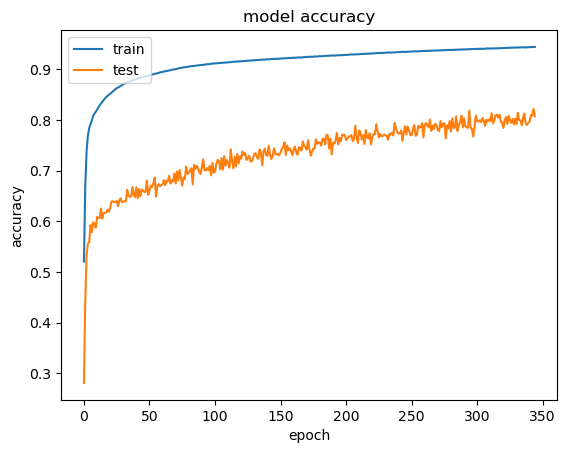

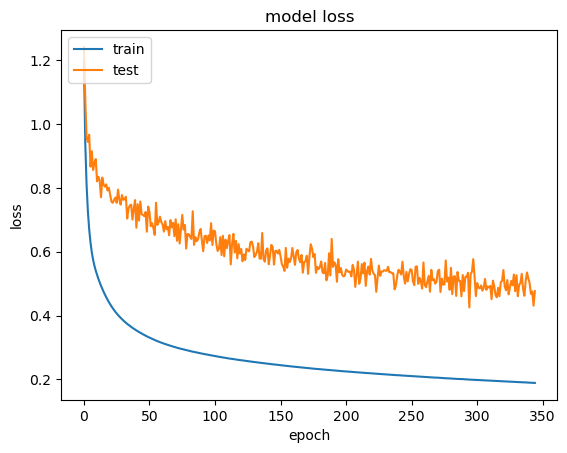

In [13]:
# EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')
batch_size = 32
epochs = 500

history = model.fit(X_train_resampled, y_train_resampled_categorical, batch_size=batch_size, epochs=epochs
                    ,validation_data=(X_val,y_val_categorical),callbacks=[earlystop])


# plot training curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

127/127 [==============================] - 0s 1ms/step


C:\Users\111064555\AppData\Local\Temp\ipykernel_15100\4122196093.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


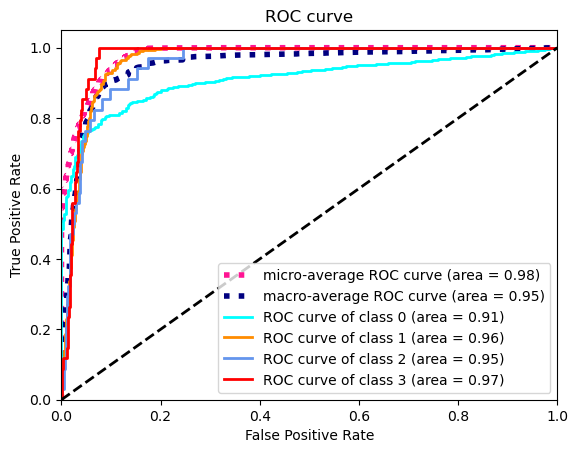

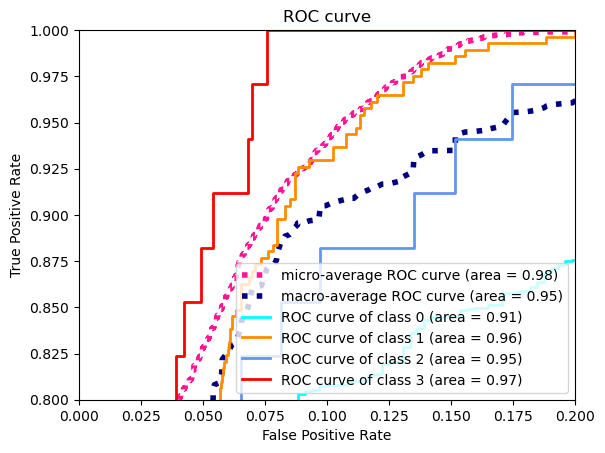

In [37]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2 # ROC的線條寬度
y_test_categorical = to_categorical(y_test, num_classes=num_classes)


# Compute ROC curve and ROC area for each class
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # AUC
n_classes = 4

y_score = model.predict(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_categorical.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

127/127 [==============================] - 0s 1ms/step
Normalized confusion matrix
[[2989  422  149  130]
 [  29  255    0    0]
 [  10    0   24    0]
 [   8    0    0   26]]


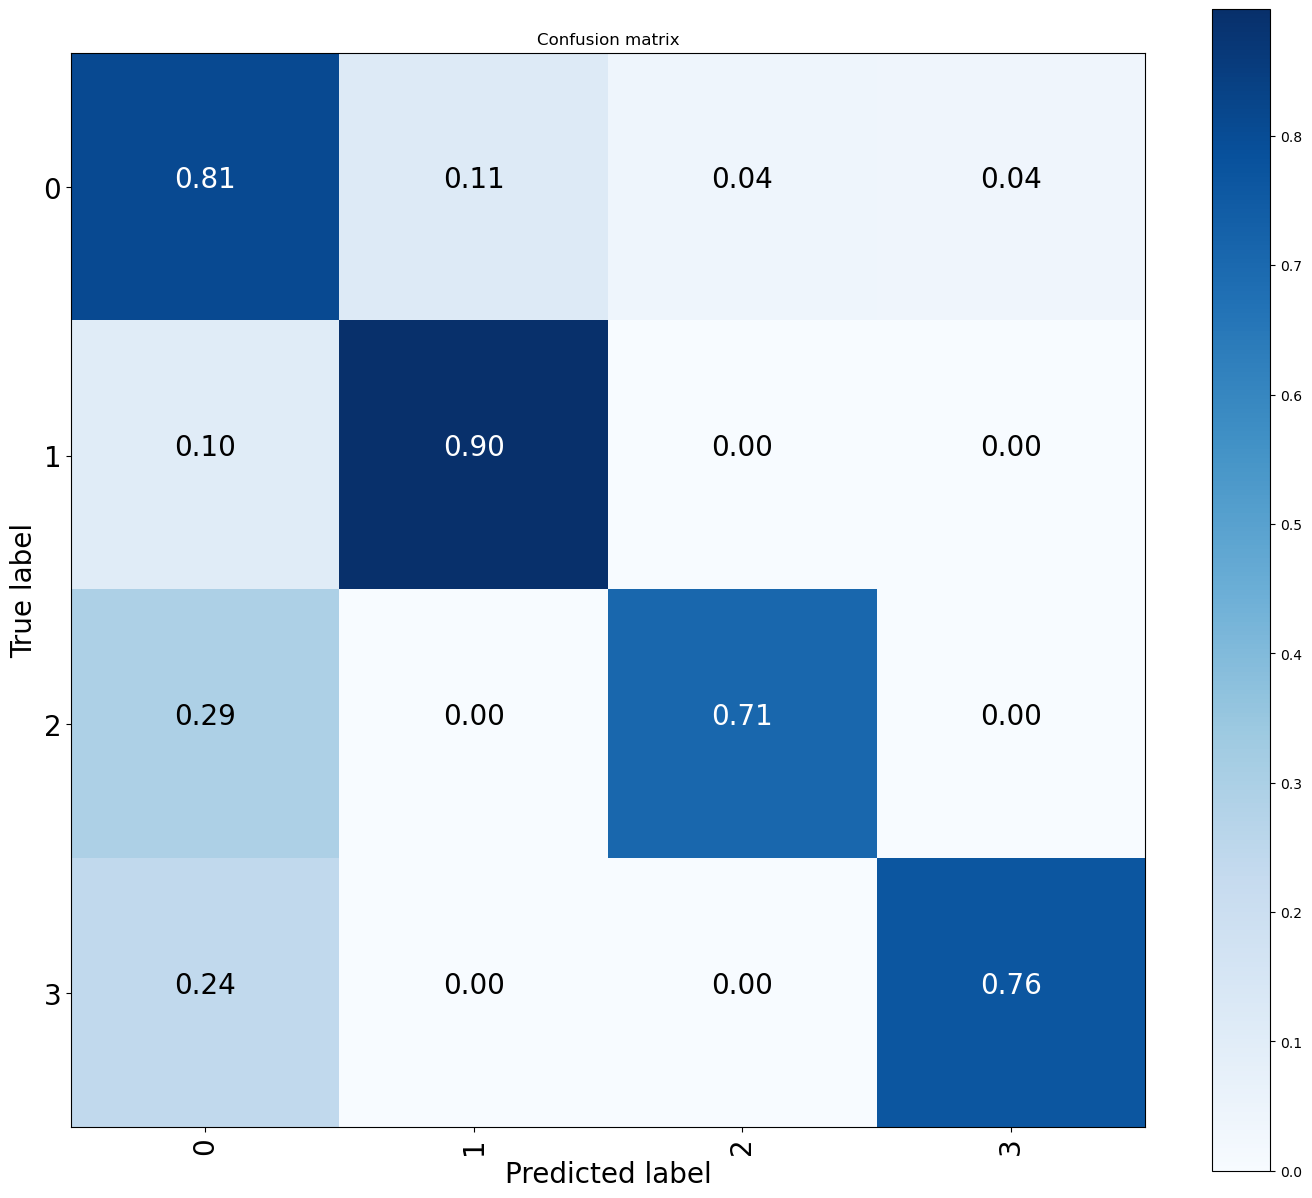

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          text_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=text_size)
    plt.yticks(tick_marks, classes, fontsize=text_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=text_size)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)

    
classes = [0,1,2,3]
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(np.argmax(y_test_categorical, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, text_size=20)
                      #title='Normalized confusion matrix'
print(cnf_matrix)

In [16]:
# SAVE MODEL
model.save("D:\\111064555\\Work\\code\\1dcnn_add1_0618.h5")
# correct version

### Trial

In [ ]:
# Load and preprocess your data
ds_x = pd.read_csv(r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_01.csv')
#ds_x = pd.read_csv(r'D:\\111064555\Work\code\Coordinate\coordinates_test_trial.csv')

# Preprocess data_x
data_x = ds_x['coordinate'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ', dtype=np.float64))

# 将 data_x 转换为 Pandas DataFrame
X_trail = pd.DataFrame(data_x.tolist(), columns=[f'coordinate_{i}' for i in range(69)]) # half=45, all=69



In [ ]:
y_pred = model.predict(X_trail)

#y_pred_trial = (y_pred > 0.5).astype(int).ravel()
y_pred_trial = np.argmax(y_pred, axis=0)
print(y_pred_trial)
#submissions=pd.DataFrame({"Label":y_pred_trial})
#submissions.to_csv("coordinate_trial1.csv",index=False,header=True)

In [ ]:
y_pred = model.predict(X_trail)
submissions=pd.DataFrame(y_pred)
submissions.to_csv("coordinate_trial_prob.csv",index=False,header=True)

## Trial

In [36]:
from tensorflow.keras.models import load_model
model_path = "D:\\111064555\\Work\\code\\\Final_Model\\Model\\nn_add1_0618.h5"
model = load_model(model_path)

In [17]:
def find_keyframes(probabilities):
    num_frames = probabilities.shape[0]
    
    sorted_indices = [np.argsort(-probabilities[:, i]) for i in range(1, 4)]

    keyframe_indices = [-1, -1, -1]  

    for idx in sorted_indices[0]:
        keyframe_indices[0] = idx
        break

    for idx in sorted_indices[1]:
        if idx > keyframe_indices[0]:
            keyframe_indices[1] = idx
            break

    for idx in sorted_indices[2]:
        if idx > keyframe_indices[1]:
            keyframe_indices[2] = idx
            break

    if -1 in keyframe_indices:
        raise ValueError("Cannot find valid keyframes that satisfy the order constraint.")
    
    return keyframe_indices

file_paths = [
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_01.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_02.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_03.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_04.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_05.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_06.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_07.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_08.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_09.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\all_coordinates_10.csv'
]

# Ground truth
true_positions = [
    [15, 36, 41],
    [56, 62, 68],
    [20, 40, 50],
    [10, 34, 40],
    [26, 45, 51],
    [22, 38, 43],
    [13, 22, 30],
    [14, 29, 40],
    [13, 36, 41],
    [9, 21, 23]
]


data_list = []
predictions = []

for file_path in file_paths:
    data = pd.read_csv(file_path)
    data = data['coordinate'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ', dtype=np.float64))
    data = pd.DataFrame(data.tolist(), columns=[f'coordinate_{i}' for i in range(69)])
    data_list.append(data)
    
    y_pred = model.predict(data)
    keyframes = find_keyframes(y_pred)
    predictions.append(keyframes)

def average_position_error(predictions, true_positions):
    keyframe_errors = []
    for i in range(3):
        errors = [abs(pred[i] - true[i]) for pred, true in zip(predictions, true_positions)]
        keyframe_errors.append(np.mean(errors))
    avg = (keyframe_errors[0]+keyframe_errors[1]+keyframe_errors[2])/3
    
    print("Average Position Errors for Keyframes:", keyframe_errors)
    print("AVG error", avg)

average_position_error(predictions, true_positions)

# 保存预测结果
output = pd.DataFrame(predictions, columns=['keyframe1', 'keyframe2', 'keyframe3'])
output.to_csv("nn_trial_keyframes.csv", index=False, header=True)

2/2 [==============================] - 0s 9ms/step
Average Position Errors for Keyframes: [6.1, 1.9, 2.3]
AVG error 3.4333333333333336


In [ ]:
### SAVE .tflite
convert = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = convert.convert()
tflite_model_file = 'coordinate_nn_bsmote_model.tflite'

with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)